In [3]:
import astropy.units as u
import matplotlib.pyplot as plt
import sys

sys.path.append("/arc/home/mseth/.local/lib/python3.11/site-packages")
import pint.fitter
from pint.models import get_model_and_toas
from pint.residuals import Residuals
import pint.logging

pint.logging.setup(level="INFO")

ModuleNotFoundError: No module named 'pint.fitter'

In [2]:
%matplotlib inline

In [3]:
%matplotlib ipympl 

## Distinguishing between MPGPs and IPGPs ##

### Load in .par and .tim files ###

In [21]:
import pint.config

parfile = 'timing/par_files/59900_60150.par'
timfile = 'timing/tim_files/new_toas_3.tim'

In [22]:
import os
os.chdir(os.path.expanduser("~"))
print(os.getcwd())

/users/mseth


In [23]:
m, t_all = get_model_and_toas(parfile, timfile)

In [24]:
rs_all = Residuals(t_all, m).time_resids.to(u.ms)
xt = t_all.get_mjds()

In [25]:
ap_mask = t_all.table["error"] >= 30 * u.us
t_gps = t_all[ap_mask]
t_gps.print_summary()

Number of TOAs:  46
Number of commands:  2
Number of observatories: 1 ['chime']
MJD span:  59873.221 to 60094.626
Date span: 2022-10-21 05:18:51.210977496 to 2023-05-30 15:01:08.311431671
chime TOAs (46):
  Min freq:      400.000 MHz
  Max freq:      400.000 MHz
  Min error:     1e+03 us
  Max error:     1e+03 us
  Median error:  1e+03 us



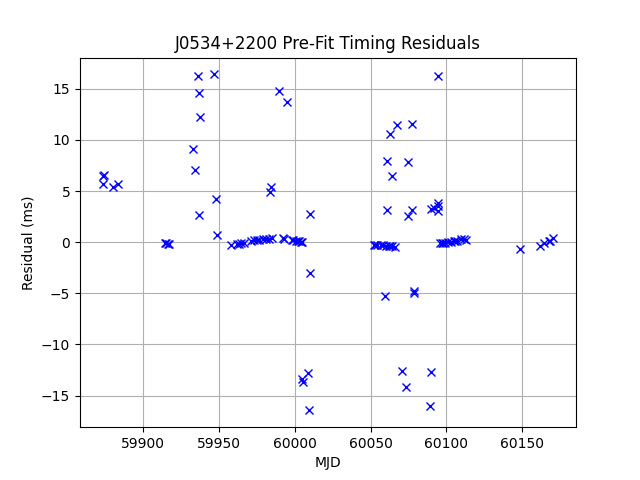

In [26]:
plt.figure()
plt.plot(xt, rs_all, "x", color='b')
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (ms)")
plt.grid()
plt.show()

### Identify GPMPs vs. GPIPs vs. APs ###

In [27]:
ap_mask = (rs_all > 1 * u.ms)|(rs_all < -1 * u.ms)

In [28]:
t_gps = t_all[ap_mask]

In [29]:
rs_gps = rs_all[ap_mask]

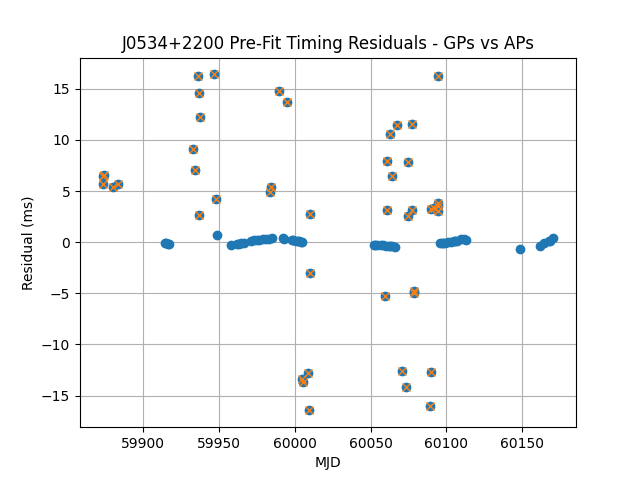

In [30]:
xt_gps = t_gps.get_mjds()

plt.figure()
plt.plot(xt, rs_all, "o")
plt.plot(xt_gps, rs_gps, "x")
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals - GPs vs APs")
plt.xlabel("MJD")
plt.ylabel("Residual (ms)")
plt.grid()

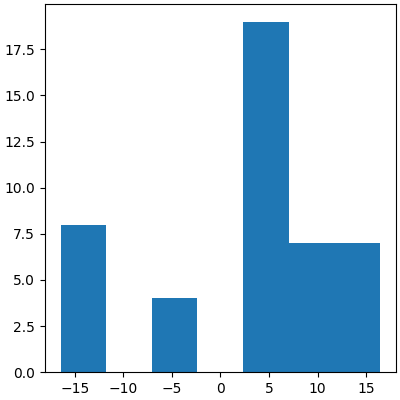

In [31]:
fig, ax = plt.subplots(
    figsize = (4, 4),
    constrained_layout = True)

ax.hist(rs_gps, 
        bins = 'auto',
        histtype = 'stepfilled')

plt.show()

In [32]:
mp_mask = (rs_gps < 10 * u.ms) & (rs_gps > -1 * u.ms)
t_mpgp = t_gps[mp_mask]
rs_mpgp = rs_gps[mp_mask]

In [33]:
t_mpgp

23 TOAs starting at MJD 59873.22142605298

In [34]:
ip_mask = (rs_gps < -10 * u.ms) & (rs_gps > -18 * u.ms)
t_ipgp = t_gps[ip_mask]
rs_ipgp = rs_gps[ip_mask]

In [35]:
t_ipgp

8 TOAs starting at MJD 60004.897625346035

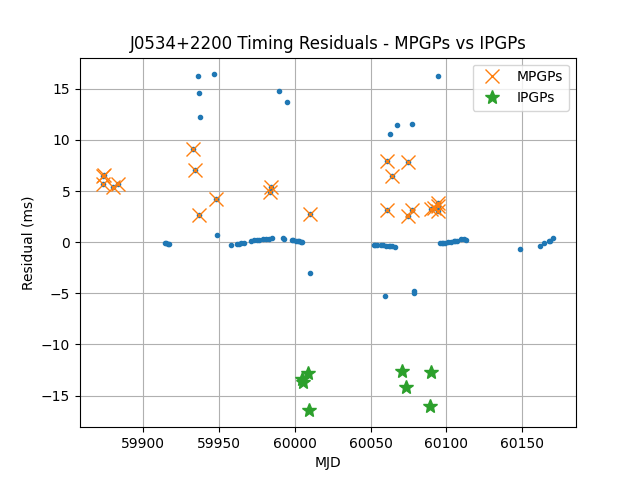

In [36]:
xt_mpgp = t_mpgp.get_mjds()
xt_ipgp = t_ipgp.get_mjds()

plt.figure()
plt.plot(xt, rs_all, "o", markersize=3)
plt.plot(xt_mpgp, rs_mpgp, "x", markersize=10, label="MPGPs")
plt.plot(xt_ipgp, rs_ipgp, "*", markersize=10, label="IPGPs")
plt.title(f"{m.PSR.value} Timing Residuals - MPGPs vs IPGPs")
plt.xlabel("MJD")
plt.ylabel("Residual (ms)")
plt.legend()
plt.grid()

### Make lists of cascade files for MPGPs and IPGPs ###

In [37]:
import os
import numpy as np

In [38]:
mpgp_toas_fit = t_mpgp.get_mjds().value
ipgp_toas_fit = t_ipgp.get_mjds().value

In [39]:
## LOAD CASCADE FILES ##

path = "/users/mseth/Documents/cascades"

cascade_files = []
for (root, dirs, file) in os.walk(path):
    for f in file: 
        cascade_files.append(os.path.join(root, f))
            
from iautils import cascade

dms = []
for cascade_file in cascade_files:
        # Load the cascade file
    try:
        cascade_obj = cascade.load_cascade_from_file(cascade_file)
        cascade_obj.dm=57.70 ## De-dispersing at 57.70
    except Exception as e:
        print(e)
        continue
    dm = cascade_obj.best_snr_dm
    dms.append(dm)

dm_filter = []

Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
De-dispersing to 57.7 pc cm-3..
Using 400.1953125 MHz as reference..
Padding shifted channels using median value..

De-dispersing to 57.7 pc cm-3..
Using 400.1953125 MHz as reference..
Padding shifted channels using median value..

De-dispersing to 57.7 pc cm-3..
Using 400.1953125 MHz as reference..
Padding shifted channels using median value..

Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
De-dispersing to 57.7 pc cm-3..
Using 400.1953125 MHz as reference..
Padding shifted channels using median value..

De-dispersing to 57.7 pc cm-3..
Using 400.1953125 MHz as reference..
Padding shifted channels using median value..

Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
De-dispersing to 57.7 pc cm-3..
Using 400.1953125 MHz as reference..
Padding shifted channels using median value..

De-dispersing to 57.7 pc cm-3..
Using 400.1953125 MHz as reference

In [40]:
## LOAD CRAB FILES (CASCADE_OBJ) ##

dms = np.array(dms)
dm_filter = np.where((dms >= 55) & (dms <= 57))[0]

crab_cascades = [cascade_files[i] for i in dm_filter]

crab_files = []

for crab_cascade in crab_cascades:
    try:
        cascade_obj = cascade.load_cascade_from_file(crab_cascade)
        #cascade_obj.dm=57.70
    except Exception as e:
        print(e)
        continue
    crab_files.append(cascade_obj)

print(crab_files)

Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing...
using L1 weights
Preprocessing.

In [41]:
## Make a list of all TOAS from CHIME data 
toas_obs = []

with open("timing/tim_files/toas.tim") as file:
    lines = file.readlines()
    for line in lines:
        columns = line.strip().split()
        try: 
            toa = columns[2]
            toa_float = float(toa)
            toas_obs.append(toa_float)
        except Exception as e:
            print(e)
            continue

list index out of range
list index out of range


In [42]:
## Make a mask to match MPGP/IPGP TOAs with the TOAs in CHIME data  
mpgp_file_mask = np.array([
    np.any(np.isclose(x, mpgp_toas_fit, atol=0.0001))
    for x in toas_obs
])

ipgp_file_mask = np.array([
    np.any(np.isclose(x, ipgp_toas_fit, atol=0.0001))
    for x in toas_obs
])

print(mpgp_file_mask)
print(ipgp_file_mask)

[ True  True  True  True  True  True  True False  True  True  True  True
 False  True False  True  True False False False False False False  True
  True False  True  True False  True False False False  True  True  True
  True False False  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False  True  True  True  True False
 False False False False False False False  True  True False False False
 False False False  True  True  True False False False False False False]


In [43]:
## Use the mask to get all CHIME cascade files of MPGPs/IPGPs
crab_files = np.array(crab_files)
crab_cascades = np.array(crab_cascades)

mpgp_files = crab_files[mpgp_file_mask]
mpgp_cascades = crab_cascades[mpgp_file_mask]

ipgp_files = crab_files[ipgp_file_mask]
ipgp_cascades = crab_cascades[ipgp_file_mask]

In [45]:
crab_cascades

array(['/users/mseth/Documents/cascades/cascade_247226617.npz',
       '/users/mseth/Documents/cascades/cascade_247263892.npz',
       '/users/mseth/Documents/cascades/cascade_247400770.npz',
       '/users/mseth/Documents/cascades/cascade_249781593.npz',
       '/users/mseth/Documents/cascades/cascade_250014167.npz',
       '/users/mseth/Documents/cascades/cascade_256372787.npz',
       '/users/mseth/Documents/cascades/cascade_256556093.npz',
       '/users/mseth/Documents/cascades/cascade_256851833.npz',
       '/users/mseth/Documents/cascades/cascade_257057841.npz',
       '/users/mseth/Documents/cascades/cascade_257070587.npz',
       '/users/mseth/Documents/cascades/cascade_257082448.npz',
       '/users/mseth/Documents/cascades/cascade_257145241.npz',
       '/users/mseth/Documents/cascades/cascade_259575617.npz',
       '/users/mseth/Documents/cascades/cascade_259705832.npz',
       '/users/mseth/Documents/cascades/cascade_259930927.npz',
       '/users/mseth/Documents/cascades/

In [46]:
np.savez('crab_files.npz', crab_filepaths=crab_cascades, crab_cascadeobj=crab_files)

In [47]:
np.savez('MPIPs.npz', mpgp_filepaths=mpgp_cascades, mpgp_cascades=mpgp_files, ipgp_filepaths=ipgp_cascades, ipgp_cascades=ipgp_files)

In [26]:
f"There are {len(mpgp_files)} MPGPs and {len(ipgp_files)} IPGPs found in the CHIME data."

'There are 32 MPGPs and 9 IPGPs found in the CHIME data.'

## Comparing MPGPs and IPGPs ##

### Plot dynamic spectra of all MPGPs and IPGPs ###

In [27]:
## Make function to make mosaic plot of all dynamic spectra ##
def plot_dynsp_mosaic(files, cascades, st_idx, ed_idx, gp_type, title_prefix):
    fig, ax = plt.subplot_mosaic(
        '''
        ABC
        DEF
        GHI
        ''',
        constrained_layout = True,
        figsize = (8, 8))

    fig.set_constrained_layout_pads(
        hspace=0.5,  
        wspace=0.5   
    )

    fig.suptitle(f"{gp_type} in CHIME data, {title_prefix}")

    ax_keys = list(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])

    for i, file in enumerate(files[st_idx:ed_idx]):
        ix = st_idx + i
        ax_key = ax_keys[i]
        ax[ax_key].imshow(files[ix].beams[files[ix]._max_beam_idx].intensity, aspect="auto")
        ax[ax_key].tick_params(axis='both', labelsize=7)

        file_name = os.path.basename(cascades[ix]).split('_')[1].split('.')[0]
        ax[ax_key].set_title(f"{file_name}, {ix}", fontsize='9')

In [28]:
# MPGP dynamic spectra 
plot_dynsp_mosaic(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=0, ed_idx=9, title_prefix="A")
plot_dynsp_mosaic(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=9, ed_idx=18, title_prefix="B")
plot_dynsp_mosaic(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=18, ed_idx=27, title_prefix="C")
plot_dynsp_mosaic(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=27, ed_idx=32, title_prefix="D")

In [29]:
# IPGP dynamic spectra 
plot_dynsp_mosaic(files=ipgp_files, cascades=ipgp_cascades, gp_type = "IPGP", st_idx=0, ed_idx=9, title_prefix="all")

### Plotting time series of all MPGPs and IPGPs ### 

In [30]:
## Make a function to plot time series of all MPGPs and IPGPs ##
def plot_tmsrs_mosaic(files, cascades, st_idx, ed_idx, gp_type, title_prefix):
    fig, ax = plt.subplot_mosaic(
        '''
        ABC
        DEF
        GHI
        ''',
        constrained_layout = True,
        figsize = (8, 8))

    fig.set_constrained_layout_pads(
        hspace=0.5,  
        wspace=0.5   
    )

    fig.suptitle(f"{gp_type} time series in CHIME data, {title_prefix}")

    ax_keys = list(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])

    for i, file in enumerate(files[st_idx:ed_idx]):
        ix = st_idx + i
        ax_key = ax_keys[i]
        ts = np.nansum(files[ix].beams[files[ix]._max_beam_idx].intensity, axis=0)
        ax[ax_key].plot(ts)

        ax[ax_key].tick_params(axis='both', labelsize=7)

        file_name = os.path.basename(cascades[ix]).split('_')[1].split('.')[0]
        ax[ax_key].set_title(f"{file_name}, {ix}", fontsize='9')

In [31]:
# Plot MPGP time series
plot_tmsrs_mosaic(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=0, ed_idx=9, title_prefix="A")
plot_tmsrs_mosaic(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=9, ed_idx=18, title_prefix="B")
plot_tmsrs_mosaic(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=18, ed_idx=27, title_prefix="C")
plot_tmsrs_mosaic(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=27, ed_idx=32, title_prefix="D")

In [32]:
# Plot IPGP time series 
plot_tmsrs_mosaic(files=ipgp_files, cascades=ipgp_cascades, gp_type = "IPGP", st_idx=0, ed_idx=9, title_prefix="all")

### Plotting both dynamic spectra and time series of MPGPs and IPGPs together ###

In [33]:
def plot_both(files, cascades, st_idx, ed_idx, gp_type, title_prefix):
    fig, axd = plt.subplot_mosaic(
        '''
        ABC
        DEF
        GHI
        JKL
        ''',
        constrained_layout = True, 
        gridspec_kw={'height_ratios':[1, 0.4, 1, 0.4]},
        figsize=(8,8),
    )

    ax_dynsp_keys = list(['A', 'B', 'C', 'G', 'H', 'I'])
    ax_tmsrs_keys = list(['D', 'E', 'F', 'J', 'K', 'L'])

    for i, file in enumerate(files[st_idx:ed_idx]):
        ax_dynsp_key = ax_dynsp_keys[i] #where to put the dynamic spectra plots
        ax_tmsrs_key = ax_tmsrs_keys[i] # where to put the time series plots

        ix = st_idx + i #get correct index 
        
        axd[ax_dynsp_key].imshow(files[ix].beams[files[ix]._max_beam_idx].intensity, aspect="auto")
        axd[ax_dynsp_key].tick_params(axis='both', labelsize=7)

        file_name = os.path.basename(cascades[ix]).split('_')[1].split('.')[0] #set title 
        axd[ax_dynsp_key].set_title(f"{file_name}, {ix}", fontsize='9')

        ts = np.nansum(files[ix].beams[files[ix]._max_beam_idx].intensity, axis=0)
        axd[ax_tmsrs_key].plot(ts)
        axd[ax_tmsrs_key].tick_params(axis='both', labelsize=7)

In [34]:
plot_both(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=0, ed_idx=6, title_prefix="A")
#plot_both(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=6, ed_idx=12, title_prefix="B")
#plot_both(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=12, ed_idx=18, title_prefix="C")
#plot_both(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=18, ed_idx=24, title_prefix="D")
#plot_both(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=24, ed_idx=30, title_prefix="E")
#plot_both(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=30, ed_idx=32, title_prefix="F")

In [35]:
plot_both(files=ipgp_files, cascades=ipgp_cascades, gp_type = "IPGP", st_idx=0, ed_idx=6, title_prefix="A")
plot_both(files=ipgp_files, cascades=ipgp_cascades, gp_type = "IPGP", st_idx=6, ed_idx=9, title_prefix="B")

#### Generating one example plot for the paper ####

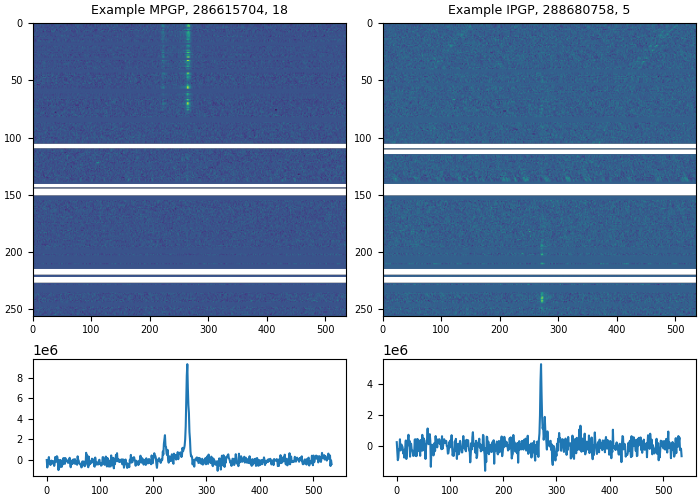

In [44]:
fig, axd = plt.subplot_mosaic(
        '''
        AB
        DC
        ''',
        constrained_layout = True, 
        gridspec_kw={'height_ratios':[1, 0.4]},
        figsize=(7,5),
    )


#MPGP
axd['A'].imshow(mpgp_files[18].beams[mpgp_files[18]._max_beam_idx].intensity, aspect="auto", cmap="viridis")
axd['A'].tick_params(axis='both', labelsize=7)

file_name = os.path.basename(mpgp_cascades[18]).split('_')[1].split('.')[0] #set title 
axd['A'].set_title(f"Example MPGP, {file_name}, {18}", fontsize='9')

ts = np.nansum(mpgp_files[18].beams[mpgp_files[18]._max_beam_idx].intensity, axis=0)
axd['D'].plot(ts)
axd['D'].tick_params(axis='both', labelsize=7)


#IPGP
axd['B'].imshow(ipgp_files[5].beams[ipgp_files[5]._max_beam_idx].intensity, aspect="auto", cmap="viridis")
axd['B'].tick_params(axis='both', labelsize=7)

file_name_ip = os.path.basename(ipgp_cascades[5]).split('_')[1].split('.')[0] #set title 
axd['B'].set_title(f"Example IPGP, {file_name_ip}, {5}", fontsize='9')

ts = np.nansum(ipgp_files[5].beams[ipgp_files[5]._max_beam_idx].intensity, axis=0)
axd['C'].plot(ts)
axd['C'].tick_params(axis='both', labelsize=7)


plt.show()

In [38]:
plot_both_one(files=mpgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=18, title_prefix="MPGP Example")
plot_both_one(files=ipgp_files, cascades=mpgp_cascades, gp_type = "MPGP", st_idx=5, title_prefix="IPGP Example")

#### (not using) try to just make it look a bit better ####

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
### Using plt.figure, subfigures, and subplots to control spacing more in detail, but I don't think it's worth it. 

fig = plt.figure(layout='constrained', figsize=(8,8)) #load in a new figure 

subfigs = fig.subfigures(2, 1, hspace=0.07) #divide it into half horizontally
subfigs[1].set_facecolor('coral')
subfigs[0].set_facecolor('coral')

#Top half 
subfigsnest_top = subfigs[0].subfigures(2, 1, hspace=0.02, height_ratios=[1, 0.4]) #Cut into three columns 

axsnest0 = subfigsnest_top[0].subplots(1, 3, sharex=True, sharey=True)
for nn, ax in enumerate(axsnest0):
    pc = ax.imshow(crab_files[0].beams[1].intensity,aspect="auto")

axsnest1 = subfigsnest_top[1].subplots(1, 3, sharex=True, sharey=True)
for nn, ax in enumerate(axsnest1):
    ts = np.nansum(crab_files[0].beams[1].intensity,axis=0)
    pc = ax.plot(ts)

subfigsnest_top[0].set_facecolor('r')
subfigsnest_top[1].set_facecolor('r')


#Bottom half
subfigsnest_bot = subfigs[1].subfigures(2, 1, hspace=0.02, height_ratios=[1, 0.4])

axsnest2= subfigsnest_bot[0].subplots(1, 3, sharex=True, sharey=True)
for nn, ax in enumerate(axsnest2):
    pc = ax.imshow(crab_files[0].beams[1].intensity,aspect="auto")

axsnest3 = subfigsnest_bot[1].subplots(1, 3, sharex=True, sharey=True)
for nn, ax in enumerate(axsnest3):
    ts = np.nansum(crab_files[0].beams[1].intensity,axis=0)
    pc = ax.plot(ts)

subfigsnest_bot[0].set_facecolor('r')
subfigsnest_bot[1].set_facecolor('r')

plt.show()

### Comparing Weff of MPGPs and IPGPs ###

In [ ]:
## Find Weff for MPGPs
W_eff_mpgp = []

for mpgp_file in mpgp_files:
    max_beam = mpgp_file._max_beam_idx
    time_srs = np.nansum(mpgp_file.beams[max_beam].intensity,axis=0)
    
    max_int = np.max(time_srs)
    max_idx = np.argmax(time_srs)

    window = np.arange(max_idx - 10, max_idx + 10, 1)

    masked_ts = [time_srs[i] for i in window]
    
    fluence = np.nansum(masked_ts, axis=0)
    w_eff = fluence/max_int
    W_eff_mpgp.append(w_eff)


print(W_eff_mpgp)

In [ ]:
## Find Weff for IPGPs 
W_eff_ipgp = []

for ipgp_file in ipgp_files:
    max_beam = ipgp_file._max_beam_idx
    time_srs = np.nansum(ipgp_file.beams[max_beam].intensity,axis=0)
    
    max_int = np.max(time_srs)
    max_idx = np.argmax(time_srs)

    window = np.arange(max_idx - 10, max_idx + 10, 1)

    masked_ts = [time_srs[i] for i in window]
    
    fluence = np.nansum(masked_ts, axis=0)
    w_eff = fluence/max_int
    W_eff_ipgp.append(w_eff)


print(W_eff_ipgp)

In [ ]:
fig, ax = plt.subplots(
    figsize = (5, 5),
    constrained_layout = True)

ax.hist(W_eff_mpgp, 
        bins = 'auto',
        histtype = 'stepfilled',
        label='MPGP widths')

ax.hist(W_eff_ipgp,
        bins='auto',
        histtype='stepfilled',
        color='g',
        label='IPGP widths')
ax.legend()
ax.set_xlabel("Effective widths");

In [ ]:
mpgp_dms = []
for mpgp_cascade in mpgp_cascades:
        # Load the cascade file
    try:
        cascade_obj = cascade.load_cascade_from_file(mpgp_cascade)
        cascade_obj.dm=56.70 ## De-dispersing at 57.70
    except Exception as e:
        print(e)
        continue
    dm = cascade_obj.best_snr_dm
    mpgp_dms.append(dm)
  

In [ ]:
print(mpgp_dms)

In [ ]:
mpgp_dms = np.array(mpgp_dms)

In [ ]:
len(W_eff_mpgp)

In [ ]:
fig, ax = plt.subplots(
    figsize = (8, 8),
    constrained_layout = True)

ax.scatter(W_eff_mpgp, mpgp_dms, marker="o", label="MPGPs")
#ax.scatter(W_eff_ipgp, migp_dms, "x", label="IPGPs")

ax.set_ylabel('DM')
ax.set_xlabel('Pulse Effective Width')
plt.legend()
plt.show()